X_train shape: (3737, 22)
y_train shape: (3737, 1)
X_test shape: (1601, 22)
y_test shape: (1601, 1)
Epoch 1/100
94/94 [==============================] - 3s 11ms/step - loss: 0.0116 - val_loss: 0.0021
Epoch 2/100
94/94 [==============================] - 0s 5ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 3/100
94/94 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 6.7363e-04
Epoch 4/100
94/94 [==============================] - 1s 9ms/step - loss: 8.9944e-04 - val_loss: 5.3788e-04
Epoch 5/100
94/94 [==============================] - 1s 11ms/step - loss: 7.6924e-04 - val_loss: 4.7752e-04
Epoch 6/100
94/94 [==============================] - 1s 16ms/step - loss: 7.0981e-04 - val_loss: 4.1175e-04
Epoch 7/100
94/94 [==============================] - 1s 9ms/step - loss: 6.6483e-04 - val_loss: 3.7093e-04
Epoch 8/100
94/94 [==============================] - 1s 10ms/step - loss: 6.1941e-04 - val_loss: 3.9491e-04
Epoch 9/100
94/94 [==============================] - 1s 16ms

94/94 [==============================] - 2s 22ms/step - loss: 3.5037e-04 - val_loss: 1.8087e-04
Epoch 76/100
94/94 [==============================] - 3s 28ms/step - loss: 3.8991e-04 - val_loss: 1.0481e-04
Epoch 77/100
94/94 [==============================] - 2s 25ms/step - loss: 3.4876e-04 - val_loss: 1.1260e-04
Epoch 78/100
94/94 [==============================] - 3s 26ms/step - loss: 3.4693e-04 - val_loss: 1.1371e-04
Epoch 79/100
94/94 [==============================] - 3s 29ms/step - loss: 3.4789e-04 - val_loss: 1.0603e-04
Epoch 80/100
94/94 [==============================] - 4s 41ms/step - loss: 3.4800e-04 - val_loss: 1.1430e-04
Epoch 81/100
94/94 [==============================] - 2s 20ms/step - loss: 3.4129e-04 - val_loss: 9.6828e-05
Epoch 82/100
94/94 [==============================] - 2s 19ms/step - loss: 3.5287e-04 - val_loss: 9.0347e-05
Epoch 83/100
94/94 [==============================] - 2s 24ms/step - loss: 3.3506e-04 - val_loss: 1.4157e-04
Epoch 84/100
94/94 [============

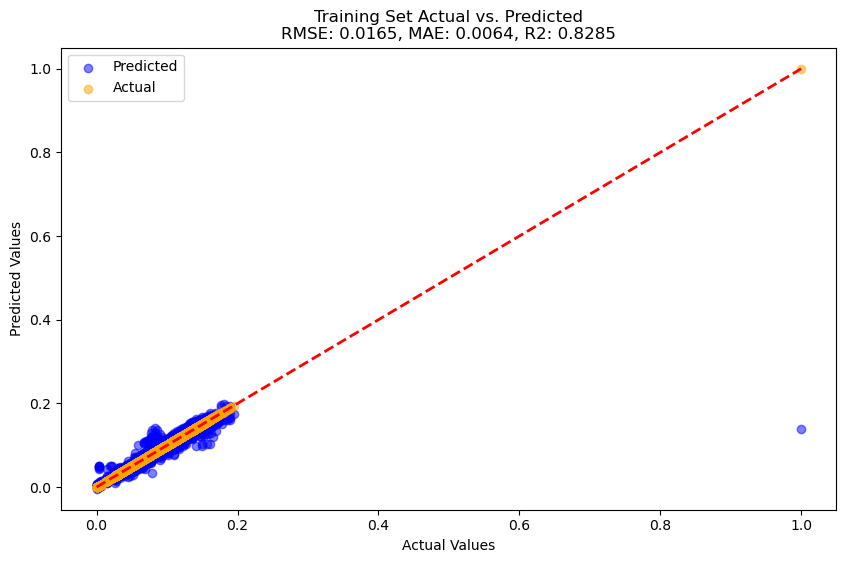

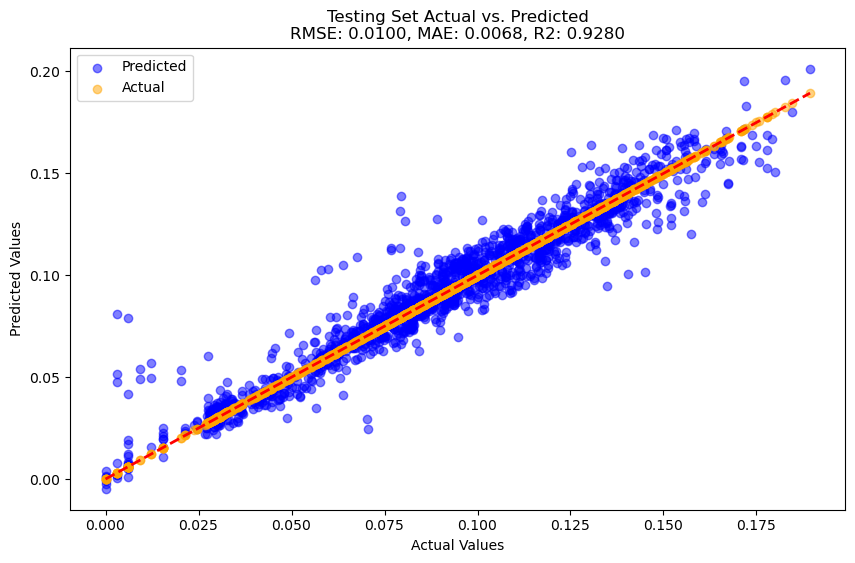

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from math import sqrt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping

# Define the file path to the Excel file
file_path = "C:/Users/Laura/OneDrive - HKUST (Guangzhou)/桌面/geological storage/pressure_splits_70_30.xlsx"

# Load the Excel file
xls = pd.ExcelFile(file_path)

# Load each sheet into a DataFrame and assign it to a variable
X_train = pd.read_excel(xls, sheet_name='X_train')
y_train = pd.read_excel(xls, sheet_name='y_train')
X_test = pd.read_excel(xls, sheet_name='X_test')
y_test = pd.read_excel(xls, sheet_name='y_test')

# Ensure all data is float and handle missing values
def clean_data(X, y):
    combined = pd.concat([X, y], axis=1)
    combined = combined.replace([np.inf, -np.inf], np.nan)
    combined = combined.dropna()
    return combined.iloc[:, :-y.shape[1]], combined.iloc[:, -y.shape[1]:]

X_train, y_train = clean_data(X_train, y_train)
X_test, y_test = clean_data(X_test, y_test)

# Optionally, print the shape of each DataFrame to verify the data
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Reshape the data for RNN
X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define the RNN model
model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Make predictions on the datasets
y_train_pred = model.predict(X_train_reshaped)
y_test_pred = model.predict(X_test_reshaped)

# Calculate metrics for each set
train_rmse = sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_rmse = sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print metrics
print(f"Training RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R2: {train_r2:.4f}")
print(f"Testing RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R2: {test_r2:.4f}")

# Function to plot the actual vs. predicted values with different colors
def plot_actual_vs_predicted(y_true, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5, label='Predicted', color='blue')
    plt.scatter(y_true, y_true, alpha=0.5, label='Actual', color='orange')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.title(title)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.show()

# Plot actual vs. predicted values for each set
plot_actual_vs_predicted(y_train.values, y_train_pred, f'Training Set Actual vs. Predicted\nRMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R2: {train_r2:.4f}')
plot_actual_vs_predicted(y_test.values, y_test_pred, f'Testing Set Actual vs. Predicted\nRMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R2: {test_r2:.4f}')


X_train shape: (4005, 22)
y_train shape: (4005, 1)
X_test shape: (1333, 22)
y_test shape: (1333, 1)
Epoch 1/100
101/101 [==============================] - 21s 60ms/step - loss: 0.0060 - val_loss: 0.0013
Epoch 2/100
101/101 [==============================] - 3s 30ms/step - loss: 0.0012 - val_loss: 8.3001e-04
Epoch 3/100
101/101 [==============================] - 3s 31ms/step - loss: 9.5770e-04 - val_loss: 7.3712e-04
Epoch 4/100
101/101 [==============================] - 2s 20ms/step - loss: 7.8230e-04 - val_loss: 4.5207e-04
Epoch 5/100
101/101 [==============================] - 3s 28ms/step - loss: 6.8973e-04 - val_loss: 5.8612e-04
Epoch 6/100
101/101 [==============================] - 3s 25ms/step - loss: 6.3565e-04 - val_loss: 4.0476e-04
Epoch 7/100
101/101 [==============================] - 2s 23ms/step - loss: 5.9178e-04 - val_loss: 5.4135e-04
Epoch 8/100
101/101 [==============================] - 3s 34ms/step - loss: 5.9423e-04 - val_loss: 3.2091e-04
Epoch 9/100
101/101 [==========

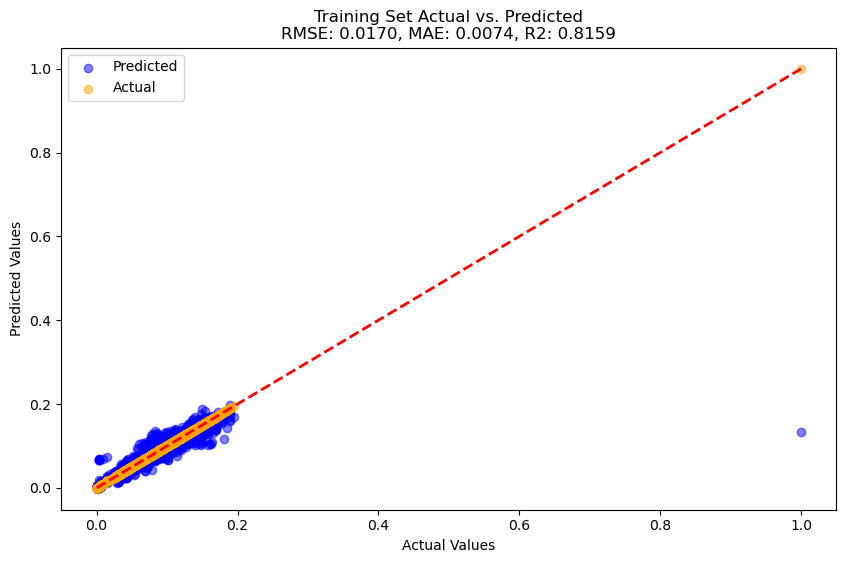

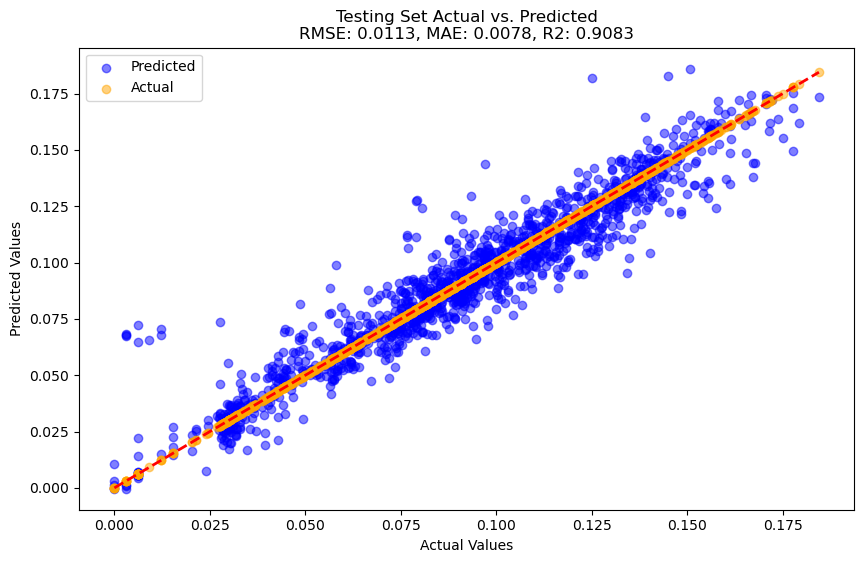

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from math import sqrt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping

# Define the file path to the Excel file
file_path = "C:/Users/Laura/OneDrive - HKUST (Guangzhou)/桌面/geological storage/pressure_splits_75_25.xlsx"

# Load the Excel file
xls = pd.ExcelFile(file_path)

# Load each sheet into a DataFrame and assign it to a variable
X_train = pd.read_excel(xls, sheet_name='X_train')
y_train = pd.read_excel(xls, sheet_name='y_train')
X_test = pd.read_excel(xls, sheet_name='X_test')
y_test = pd.read_excel(xls, sheet_name='y_test')

# Ensure all data is float and handle missing values
def clean_data(X, y):
    combined = pd.concat([X, y], axis=1)
    combined = combined.replace([np.inf, -np.inf], np.nan)
    combined = combined.dropna()
    return combined.iloc[:, :-y.shape[1]], combined.iloc[:, -y.shape[1]:]

X_train, y_train = clean_data(X_train, y_train)
X_test, y_test = clean_data(X_test, y_test)

# Optionally, print the shape of each DataFrame to verify the data
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Reshape the data for RNN
X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define the RNN model
model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Make predictions on the datasets
y_train_pred = model.predict(X_train_reshaped)
y_test_pred = model.predict(X_test_reshaped)

# Calculate metrics for each set
train_rmse = sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_rmse = sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print metrics
print(f"Training RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R2: {train_r2:.4f}")
print(f"Testing RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R2: {test_r2:.4f}")

# Function to plot the actual vs. predicted values with different colors
def plot_actual_vs_predicted(y_true, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5, label='Predicted', color='blue')
    plt.scatter(y_true, y_true, alpha=0.5, label='Actual', color='orange')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.title(title)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.show()

# Plot actual vs. predicted values for each set
plot_actual_vs_predicted(y_train.values, y_train_pred, f'Training Set Actual vs. Predicted\nRMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R2: {train_r2:.4f}')
plot_actual_vs_predicted(y_test.values, y_test_pred, f'Testing Set Actual vs. Predicted\nRMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R2: {test_r2:.4f}')


X_train shape: (4271, 22)
y_train shape: (4271, 1)
X_test shape: (1067, 22)
y_test shape: (1067, 1)
Epoch 1/100
107/107 [==============================] - 10s 41ms/step - loss: 0.0124 - val_loss: 0.0023
Epoch 2/100
107/107 [==============================] - 3s 24ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 3/100
107/107 [==============================] - 2s 19ms/step - loss: 0.0012 - val_loss: 8.3988e-04
Epoch 4/100
107/107 [==============================] - 2s 15ms/step - loss: 9.0294e-04 - val_loss: 5.9370e-04
Epoch 5/100
107/107 [==============================] - 2s 16ms/step - loss: 7.9431e-04 - val_loss: 4.7550e-04
Epoch 6/100
107/107 [==============================] - 2s 17ms/step - loss: 6.9291e-04 - val_loss: 4.0338e-04
Epoch 7/100
107/107 [==============================] - 2s 16ms/step - loss: 6.3201e-04 - val_loss: 3.7583e-04
Epoch 8/100
107/107 [==============================] - 2s 16ms/step - loss: 5.9769e-04 - val_loss: 3.2522e-04
Epoch 9/100
107/107 [==================

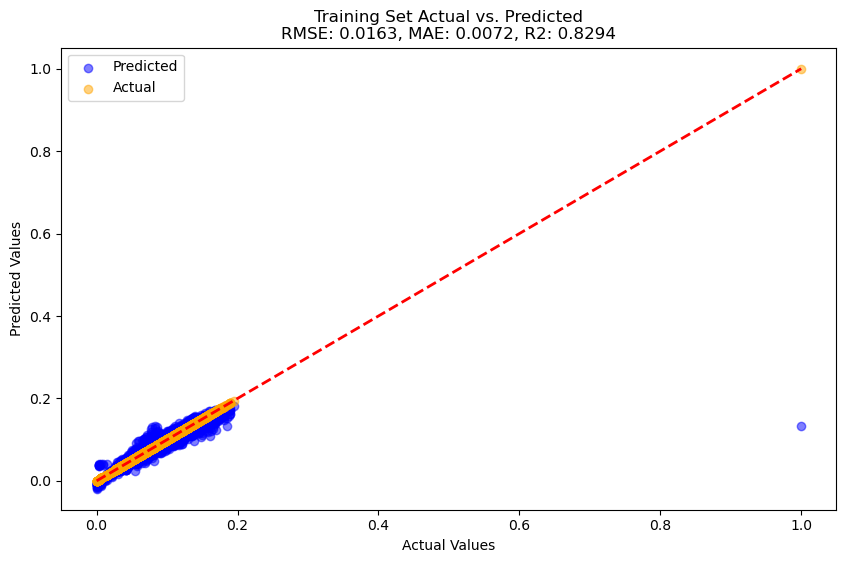

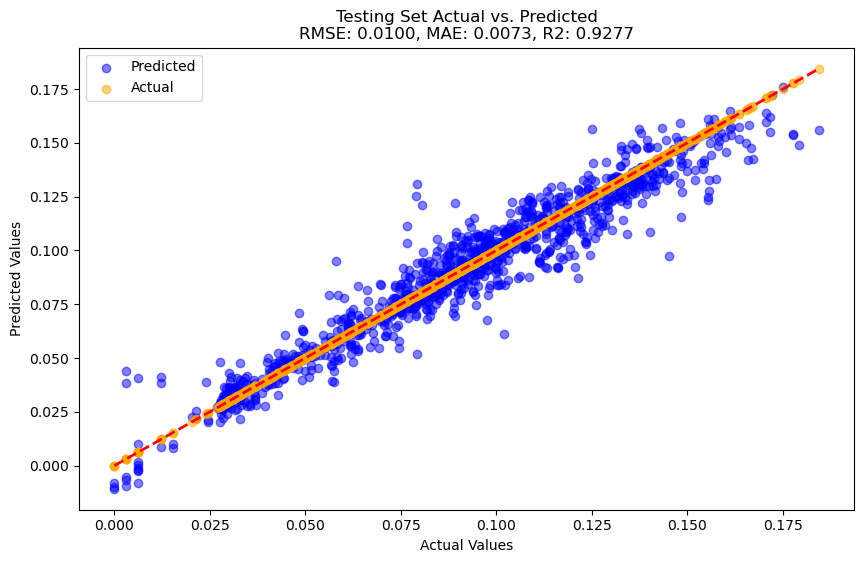

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from math import sqrt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping

# Define the file path to the Excel file
file_path = "C:/Users/Laura/OneDrive - HKUST (Guangzhou)/桌面/geological storage/pressure_splits_80_20.xlsx"

# Load the Excel file
xls = pd.ExcelFile(file_path)

# Load each sheet into a DataFrame and assign it to a variable
X_train = pd.read_excel(xls, sheet_name='X_train')
y_train = pd.read_excel(xls, sheet_name='y_train')
X_test = pd.read_excel(xls, sheet_name='X_test')
y_test = pd.read_excel(xls, sheet_name='y_test')

# Ensure all data is float and handle missing values
def clean_data(X, y):
    combined = pd.concat([X, y], axis=1)
    combined = combined.replace([np.inf, -np.inf], np.nan)
    combined = combined.dropna()
    return combined.iloc[:, :-y.shape[1]], combined.iloc[:, -y.shape[1]:]

X_train, y_train = clean_data(X_train, y_train)
X_test, y_test = clean_data(X_test, y_test)

# Optionally, print the shape of each DataFrame to verify the data
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Reshape the data for RNN
X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define the RNN model
model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Make predictions on the datasets
y_train_pred = model.predict(X_train_reshaped)
y_test_pred = model.predict(X_test_reshaped)

# Calculate metrics for each set
train_rmse = sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_rmse = sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print metrics
print(f"Training RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R2: {train_r2:.4f}")
print(f"Testing RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R2: {test_r2:.4f}")

# Function to plot the actual vs. predicted values with different colors
def plot_actual_vs_predicted(y_true, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5, label='Predicted', color='blue')
    plt.scatter(y_true, y_true, alpha=0.5, label='Actual', color='orange')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.title(title)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.show()

# Plot actual vs. predicted values for each set
plot_actual_vs_predicted(y_train.values, y_train_pred, f'Training Set Actual vs. Predicted\nRMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R2: {train_r2:.4f}')
plot_actual_vs_predicted(y_test.values, y_test_pred, f'Testing Set Actual vs. Predicted\nRMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R2: {test_r2:.4f}')


X_train shape: (101, 26)
y_train shape: (101, 1)
X_test shape: (44, 26)
y_test shape: (44, 1)
Epoch 1/100
3/3 [==============================] - 12s 1s/step - loss: 0.0801 - val_loss: 0.0262
Epoch 2/100
3/3 [==============================] - 1s 252ms/step - loss: 0.0575 - val_loss: 0.0259
Epoch 3/100
3/3 [==============================] - 0s 247ms/step - loss: 0.0448 - val_loss: 0.0296
Epoch 4/100
3/3 [==============================] - 1s 434ms/step - loss: 0.0393 - val_loss: 0.0324
Epoch 5/100
3/3 [==============================] - 1s 218ms/step - loss: 0.0363 - val_loss: 0.0311
Epoch 6/100
3/3 [==============================] - 0s 215ms/step - loss: 0.0325 - val_loss: 0.0267
Epoch 7/100
3/3 [==============================] - 0s 221ms/step - loss: 0.0273 - val_loss: 0.0215
Epoch 8/100
3/3 [==============================] - 1s 260ms/step - loss: 0.0227 - val_loss: 0.0170
Epoch 9/100
3/3 [==============================] - 1s 323ms/step - loss: 0.0196 - val_loss: 0.0140
Epoch 10/100
3/3 

3/3 [==============================] - 1s 397ms/step - loss: 7.6690e-04 - val_loss: 0.0032
Epoch 82/100
3/3 [==============================] - 1s 506ms/step - loss: 7.4799e-04 - val_loss: 0.0032
Epoch 83/100
3/3 [==============================] - 1s 251ms/step - loss: 7.3199e-04 - val_loss: 0.0031
Epoch 84/100
3/3 [==============================] - 1s 341ms/step - loss: 7.0876e-04 - val_loss: 0.0031
Epoch 85/100
3/3 [==============================] - 0s 249ms/step - loss: 7.0139e-04 - val_loss: 0.0031
Epoch 86/100
3/3 [==============================] - 1s 324ms/step - loss: 6.8148e-04 - val_loss: 0.0031
Epoch 87/100
3/3 [==============================] - 0s 238ms/step - loss: 6.7369e-04 - val_loss: 0.0031
Epoch 88/100
3/3 [==============================] - 0s 228ms/step - loss: 6.5239e-04 - val_loss: 0.0031
Epoch 89/100
3/3 [==============================] - 1s 302ms/step - loss: 6.4045e-04 - val_loss: 0.0031
Epoch 90/100
3/3 [==============================] - 0s 224ms/step - loss: 6.2

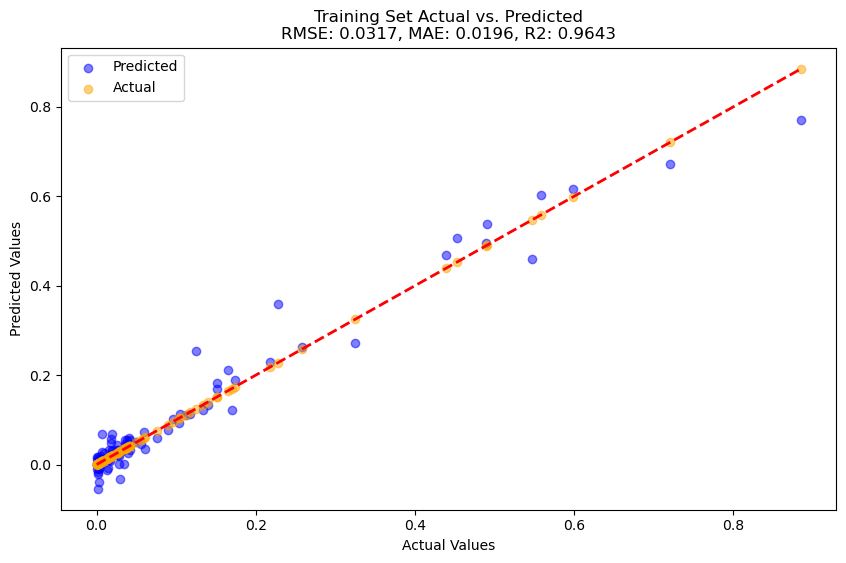

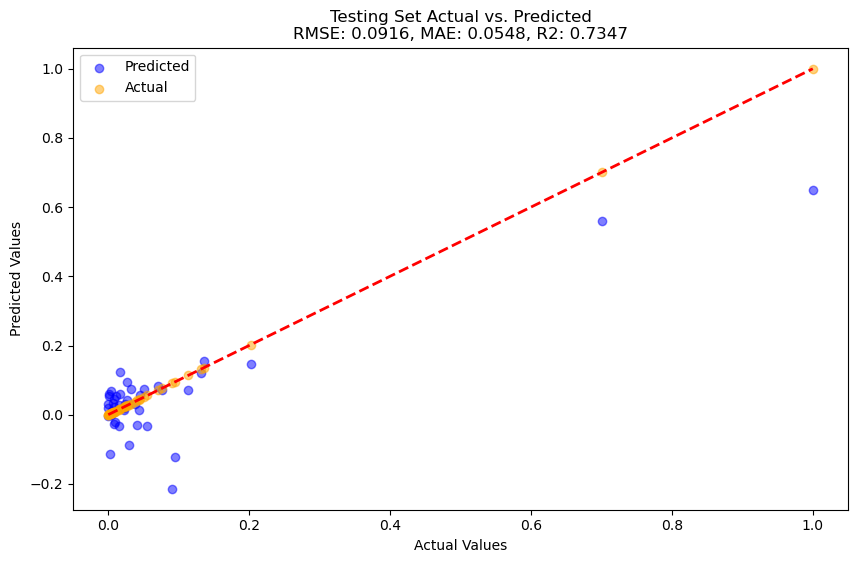

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from math import sqrt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping

# Define the file path to the Excel file
file_path = "C:/Users/Laura/OneDrive - HKUST (Guangzhou)/桌面/geological storage/capacity_splits_70_30.xlsx"

# Load the Excel file
xls = pd.ExcelFile(file_path)

# Load each sheet into a DataFrame and assign it to a variable
X_train = pd.read_excel(xls, sheet_name='X_train')
y_train = pd.read_excel(xls, sheet_name='y_train')
X_test = pd.read_excel(xls, sheet_name='X_test')
y_test = pd.read_excel(xls, sheet_name='y_test')

# Ensure all data is float and handle missing values
def clean_data(X, y):
    combined = pd.concat([X, y], axis=1)
    combined = combined.replace([np.inf, -np.inf], np.nan)
    combined = combined.dropna()
    return combined.iloc[:, :-y.shape[1]], combined.iloc[:, -y.shape[1]:]

X_train, y_train = clean_data(X_train, y_train)
X_test, y_test = clean_data(X_test, y_test)

# Optionally, print the shape of each DataFrame to verify the data
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Reshape the data for RNN
X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define the RNN model
model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Make predictions on the datasets
y_train_pred = model.predict(X_train_reshaped)
y_test_pred = model.predict(X_test_reshaped)

# Calculate metrics for each set
train_rmse = sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_rmse = sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print metrics
print(f"Training RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R2: {train_r2:.4f}")
print(f"Testing RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R2: {test_r2:.4f}")

# Function to plot the actual vs. predicted values with different colors
def plot_actual_vs_predicted(y_true, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5, label='Predicted', color='blue')
    plt.scatter(y_true, y_true, alpha=0.5, label='Actual', color='orange')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.title(title)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.show()

# Plot actual vs. predicted values for each set
plot_actual_vs_predicted(y_train.values, y_train_pred, f'Training Set Actual vs. Predicted\nRMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R2: {train_r2:.4f}')
plot_actual_vs_predicted(y_test.values, y_test_pred, f'Testing Set Actual vs. Predicted\nRMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R2: {test_r2:.4f}')


X_train shape: (108, 26)
y_train shape: (108, 1)
X_test shape: (37, 26)
y_test shape: (37, 1)
Epoch 1/100
3/3 [==============================] - 8s 2s/step - loss: 0.0980 - val_loss: 0.0434
Epoch 2/100
3/3 [==============================] - 1s 362ms/step - loss: 0.0412 - val_loss: 0.0146
Epoch 3/100
3/3 [==============================] - 1s 282ms/step - loss: 0.0153 - val_loss: 0.0099
Epoch 4/100
3/3 [==============================] - 1s 371ms/step - loss: 0.0136 - val_loss: 0.0167
Epoch 5/100
3/3 [==============================] - 1s 528ms/step - loss: 0.0190 - val_loss: 0.0205
Epoch 6/100
3/3 [==============================] - 1s 473ms/step - loss: 0.0208 - val_loss: 0.0181
Epoch 7/100
3/3 [==============================] - 1s 311ms/step - loss: 0.0170 - val_loss: 0.0127
Epoch 8/100
3/3 [==============================] - 0s 164ms/step - loss: 0.0114 - val_loss: 0.0091
Epoch 9/100
3/3 [==============================] - 1s 418ms/step - loss: 0.0083 - val_loss: 0.0080
Epoch 10/100
3/3 [

3/3 [==============================] - 1s 292ms/step - loss: 9.7342e-04 - val_loss: 0.0037
Epoch 83/100
3/3 [==============================] - 1s 311ms/step - loss: 9.6238e-04 - val_loss: 0.0037
Epoch 84/100
3/3 [==============================] - 1s 549ms/step - loss: 9.3749e-04 - val_loss: 0.0038
Epoch 85/100
3/3 [==============================] - 1s 414ms/step - loss: 9.2036e-04 - val_loss: 0.0038
Epoch 86/100
3/3 [==============================] - 0s 239ms/step - loss: 8.9643e-04 - val_loss: 0.0039
Epoch 87/100
3/3 [==============================] - 1s 528ms/step - loss: 8.8121e-04 - val_loss: 0.0038
Epoch 88/100
3/3 [==============================] - 0s 243ms/step - loss: 8.6597e-04 - val_loss: 0.0038
Epoch 89/100
3/3 [==============================] - 1s 365ms/step - loss: 8.4781e-04 - val_loss: 0.0038
Epoch 90/100
3/3 [==============================] - 1s 358ms/step - loss: 8.3816e-04 - val_loss: 0.0037
Epoch 91/100
3/3 [==============================] - 1s 253ms/step - loss: 8.2

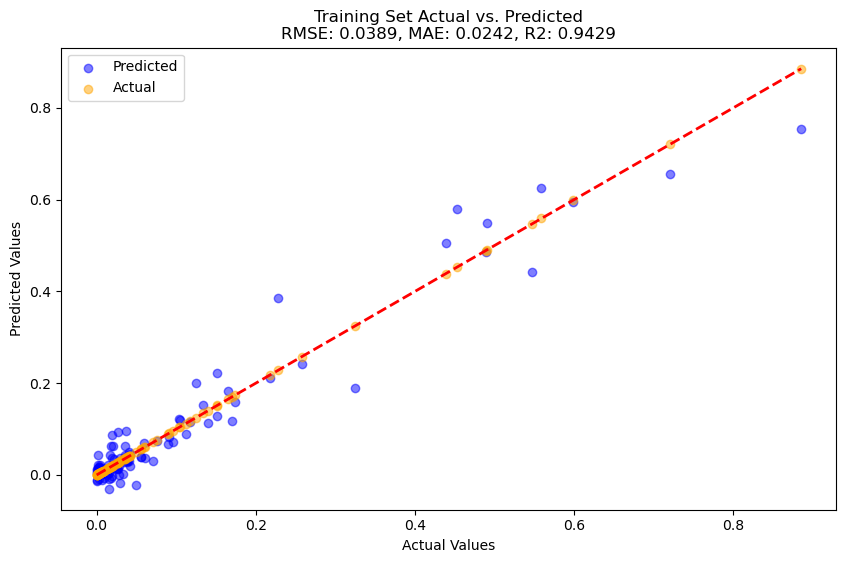

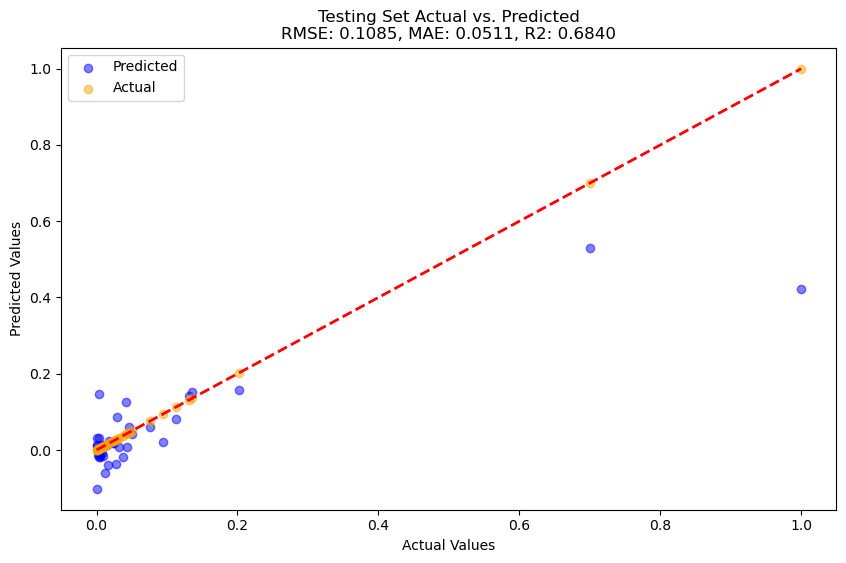

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from math import sqrt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping

# Define the file path to the Excel file
file_path = "C:/Users/Laura/OneDrive - HKUST (Guangzhou)/桌面/geological storage/capacity_splits_75_25.xlsx"

# Load the Excel file
xls = pd.ExcelFile(file_path)

# Load each sheet into a DataFrame and assign it to a variable
X_train = pd.read_excel(xls, sheet_name='X_train')
y_train = pd.read_excel(xls, sheet_name='y_train')
X_test = pd.read_excel(xls, sheet_name='X_test')
y_test = pd.read_excel(xls, sheet_name='y_test')

# Ensure all data is float and handle missing values
def clean_data(X, y):
    combined = pd.concat([X, y], axis=1)
    combined = combined.replace([np.inf, -np.inf], np.nan)
    combined = combined.dropna()
    return combined.iloc[:, :-y.shape[1]], combined.iloc[:, -y.shape[1]:]

X_train, y_train = clean_data(X_train, y_train)
X_test, y_test = clean_data(X_test, y_test)

# Optionally, print the shape of each DataFrame to verify the data
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Reshape the data for RNN
X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define the RNN model
model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Make predictions on the datasets
y_train_pred = model.predict(X_train_reshaped)
y_test_pred = model.predict(X_test_reshaped)

# Calculate metrics for each set
train_rmse = sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_rmse = sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print metrics
print(f"Training RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R2: {train_r2:.4f}")
print(f"Testing RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R2: {test_r2:.4f}")

# Function to plot the actual vs. predicted values with different colors
def plot_actual_vs_predicted(y_true, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5, label='Predicted', color='blue')
    plt.scatter(y_true, y_true, alpha=0.5, label='Actual', color='orange')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.title(title)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.show()

# Plot actual vs. predicted values for each set
plot_actual_vs_predicted(y_train.values, y_train_pred, f'Training Set Actual vs. Predicted\nRMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R2: {train_r2:.4f}')
plot_actual_vs_predicted(y_test.values, y_test_pred, f'Testing Set Actual vs. Predicted\nRMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R2: {test_r2:.4f}')


X_train shape: (116, 26)
y_train shape: (116, 1)
X_test shape: (29, 26)
y_test shape: (29, 1)
Epoch 1/100
3/3 [==============================] - 6s 812ms/step - loss: 0.2622 - val_loss: 0.1512
Epoch 2/100
3/3 [==============================] - 0s 114ms/step - loss: 0.1799 - val_loss: 0.0940
Epoch 3/100
3/3 [==============================] - 0s 130ms/step - loss: 0.1154 - val_loss: 0.0542
Epoch 4/100
3/3 [==============================] - 0s 123ms/step - loss: 0.0680 - val_loss: 0.0317
Epoch 5/100
3/3 [==============================] - 0s 160ms/step - loss: 0.0393 - val_loss: 0.0233
Epoch 6/100
3/3 [==============================] - 0s 88ms/step - loss: 0.0236 - val_loss: 0.0245
Epoch 7/100
3/3 [==============================] - 0s 119ms/step - loss: 0.0216 - val_loss: 0.0298
Epoch 8/100
3/3 [==============================] - 0s 154ms/step - loss: 0.0233 - val_loss: 0.0342
Epoch 9/100
3/3 [==============================] - 0s 118ms/step - loss: 0.0258 - val_loss: 0.0347
Epoch 10/100
3/3

3/3 [==============================] - 0s 108ms/step - loss: 0.0010 - val_loss: 0.0062
Epoch 83/100
3/3 [==============================] - 0s 78ms/step - loss: 0.0010 - val_loss: 0.0063
Epoch 84/100
3/3 [==============================] - 0s 126ms/step - loss: 0.0010 - val_loss: 0.0063
Epoch 85/100
3/3 [==============================] - 0s 103ms/step - loss: 9.8857e-04 - val_loss: 0.0061
Epoch 86/100
3/3 [==============================] - 0s 130ms/step - loss: 9.6859e-04 - val_loss: 0.0061
Epoch 87/100
3/3 [==============================] - 0s 113ms/step - loss: 9.6436e-04 - val_loss: 0.0062
Epoch 88/100
3/3 [==============================] - 0s 88ms/step - loss: 9.3269e-04 - val_loss: 0.0061
Epoch 89/100
3/3 [==============================] - 0s 116ms/step - loss: 9.1884e-04 - val_loss: 0.0061
Epoch 90/100
3/3 [==============================] - 0s 71ms/step - loss: 9.0369e-04 - val_loss: 0.0060
Epoch 91/100
3/3 [==============================] - 0s 97ms/step - loss: 8.9187e-04 - val_lo

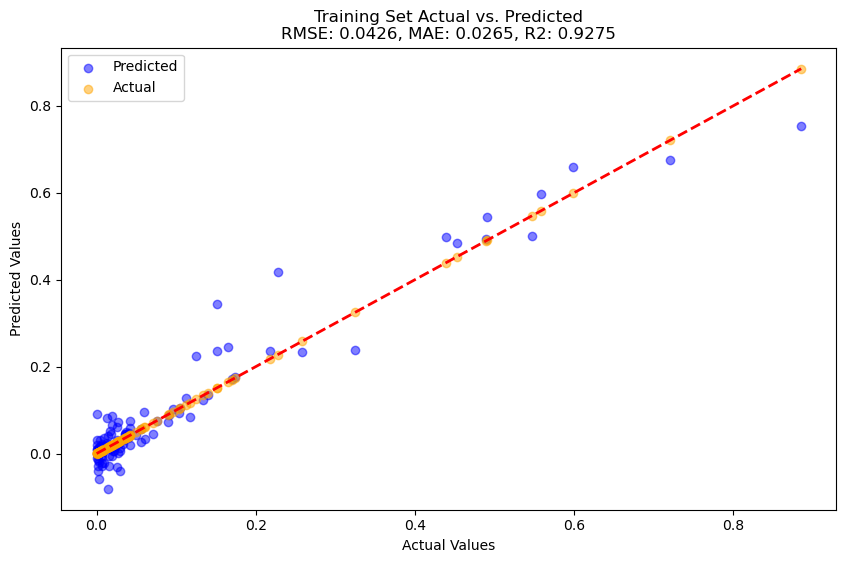

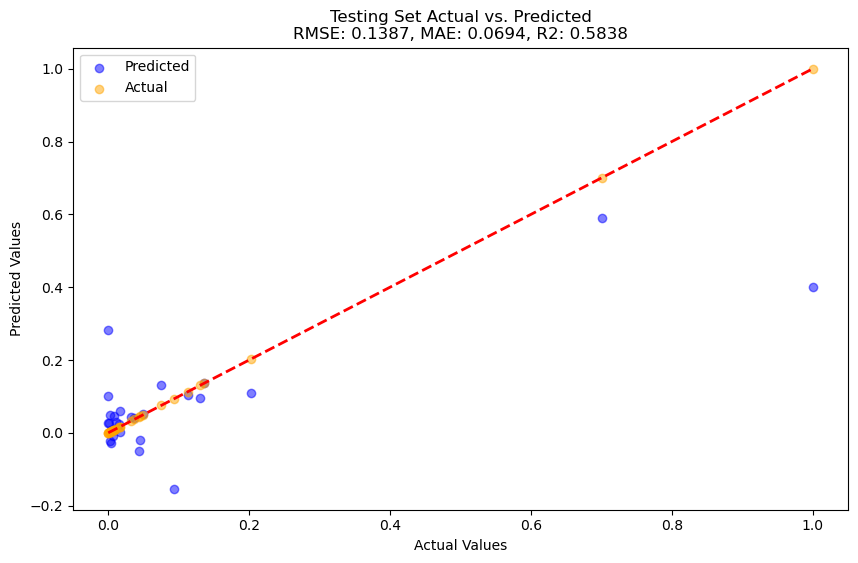

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from math import sqrt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping

# Define the file path to the Excel file
file_path = "C:/Users/Laura/OneDrive - HKUST (Guangzhou)/桌面/geological storage/capacity_splits_80_20.xlsx"

# Load the Excel file
xls = pd.ExcelFile(file_path)

# Load each sheet into a DataFrame and assign it to a variable
X_train = pd.read_excel(xls, sheet_name='X_train')
y_train = pd.read_excel(xls, sheet_name='y_train')
X_test = pd.read_excel(xls, sheet_name='X_test')
y_test = pd.read_excel(xls, sheet_name='y_test')

# Ensure all data is float and handle missing values
def clean_data(X, y):
    combined = pd.concat([X, y], axis=1)
    combined = combined.replace([np.inf, -np.inf], np.nan)
    combined = combined.dropna()
    return combined.iloc[:, :-y.shape[1]], combined.iloc[:, -y.shape[1]:]

X_train, y_train = clean_data(X_train, y_train)
X_test, y_test = clean_data(X_test, y_test)

# Optionally, print the shape of each DataFrame to verify the data
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Reshape the data for RNN
X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define the RNN model
model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Make predictions on the datasets
y_train_pred = model.predict(X_train_reshaped)
y_test_pred = model.predict(X_test_reshaped)

# Calculate metrics for each set
train_rmse = sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_rmse = sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print metrics
print(f"Training RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R2: {train_r2:.4f}")
print(f"Testing RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R2: {test_r2:.4f}")

# Function to plot the actual vs. predicted values with different colors
def plot_actual_vs_predicted(y_true, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5, label='Predicted', color='blue')
    plt.scatter(y_true, y_true, alpha=0.5, label='Actual', color='orange')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.title(title)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.show()

# Plot actual vs. predicted values for each set
plot_actual_vs_predicted(y_train.values, y_train_pred, f'Training Set Actual vs. Predicted\nRMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R2: {train_r2:.4f}')
plot_actual_vs_predicted(y_test.values, y_test_pred, f'Testing Set Actual vs. Predicted\nRMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R2: {test_r2:.4f}')
